In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
AEdata = pd.read_csv("cleaned_AE_data.csv")

In [3]:
AEdata['Period'] = pd.to_datetime(AEdata['Period'])

In [4]:
AEdata = AEdata.set_index('Period')

In [5]:
Emergency_admissions = AEdata['Total Emergency Admissions']

In [6]:
## 1. Split main dataset into Train Validation and Hold subsets of data
## Train (70%, 84), Validation (20%, 24), Hold (10%, 12). Total rows 120

In [7]:
# Training dataset (70%, 84)
traindata = Emergency_admissions.iloc[0:84]

In [8]:
# Validation dataset (20%, 24)
valdata = Emergency_admissions.iloc[83:108]

In [9]:
# Hold dataset (10%, 12)
hold = Emergency_admissions[107:115]

In [10]:
traindataf = traindata.to_frame().apply(np.int64)

In [11]:
# Renmae variable now as a dataframe
traindataf.rename(columns={'Total Emergency Admissions':'Emadmissions'})

,Emadmissions
Period,
2010-08-01,425702
2010-09-01,424900
2010-10-01,436215
2010-11-01,429099
2010-12-01,452728
...,...
2017-03-01,509805
2017-04-01,471328
2017-05-01,505843


In [12]:
valdataf = valdata.to_frame().apply(np.int64)

In [13]:
valdataf.rename(columns={'Total Emergency Admissions':'Emadmissions'})

,Emadmissions
Period,
2017-07-01,499259
2017-08-01,486074
2017-09-01,486799
2017-10-01,513217
2017-11-01,513019
2017-12-01,520803
2018-01-01,526045
2018-02-01,476867
2018-03-01,526066


## 4 Data preparation for the RNN Neural Network 

In [15]:
### Scale the data 

#### We need to scale the data using the MinMaxScaler() 

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
# The dataset will be scaled between 0  and 1 
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0,1))

In [18]:
###  4.1The MinMaxScaler function must be aaplied on a DataFrame.

In [19]:
#### 4.1.1 Train datasets:  It expects a 2d object 
#### traindataf is allready a Pandas Dataframe

In [20]:
Traindata = scaler.fit_transform(traindataf)

In [21]:
#### 4.2 Once the dataset has been scaled we need to turn it back into a Series object for the Network model build

In [22]:
flat_Traindata = Traindata.flatten()

In [23]:
Traindata_scaled = pd.Series(flat_Traindata,
                            index=traindataf.index)

In [24]:
#### 1-2 Target dataset 

In [25]:
total_lags = 5

###  4.3 Build Target and Features datasets based on Traindata_scaled dataset 

## TARGET train dataset Y_train 

In [62]:
Y_train = Traindata_scaled.iloc[5:,]

## FEATURES train dataset X_train This is the reversed dataframe 

In [63]:
## Reverse order defined by (total_lags,0,-1)

In [64]:
def get_features(data,total_lags):
    col_list=[]
    for time_lag in range(total_lags,0, -1):
        Lag_i = pd.DataFrame(data.shift(time_lag+1,axis=0,fill_value=0))
        col_list.append(Lag_i)
        features_array = pd.concat(col_list,axis=1)
        trunc_dataset = features_array.iloc[total_lags:]
    return trunc_dataset

In [65]:
X_train_rev = get_features(Traindata_scaled,total_lags)

In [66]:
type(X_train_rev)

pandas.core.frame.DataFrame

In [67]:
X_train_rev[0:10]

,0,0,0,0,0
Period,,,,,
2011-01-01,0.000000,0.225564,0.218179,0.322369,0.256844
2011-02-01,0.225564,0.218179,0.322369,0.256844,0.474424
2011-03-01,0.218179,0.322369,0.256844,0.474424,0.375666
2011-04-01,0.322369,0.256844,0.474424,0.375666,0.000000
2011-05-01,0.256844,0.474424,0.375666,0.000000,0.420252
2011-06-01,0.474424,0.375666,0.000000,0.420252,0.166088
2011-07-01,0.375666,0.000000,0.420252,0.166088,0.240057
2011-08-01,0.000000,0.420252,0.166088,0.240057,0.111548
2011-09-01,0.420252,0.166088,0.240057,0.111548,0.226439


In [68]:
X_train_array = np.array(X_train_rev)

In [81]:
X_train_array.shape

(79, 5)

In [69]:
## Copy dataset
X_train_array_MODEL = X_train_array[:,:,np.newaxis]

#### Check in your Features TRAIN dataset you have THREE dimensions now 

In [70]:
#### Check in your Features TRAIN dataset you have THREE dimensions now 
X_train_array[:,:,np.newaxis].shape

(79, 5, 1)

In [71]:
X_train_array_MODEL.shape

(79, 5, 1)

In [ ]:
# 75 samples 
# 5 sequence lags
# 1 feature

## TARGET Validation dataset Y_val 

In [42]:
### Scale the validation dataset 

In [43]:
Valdata = scaler.fit_transform(valdataf)

#### 4.2 Once the dataset has been scaled we need to turn it back into a Series object for the Network model build

In [72]:
flat_Valdata = Valdata.flatten()

In [73]:
Valdata_scaled = pd.Series(flat_Valdata,
                            index=valdataf.index)

In [74]:
total_lags = 5

###  4.3 Build Target and Features datasets based on Valdata_scaled dataset 

## TARGET validation dataset Y_val

In [75]:
Y_val = Valdata_scaled.iloc[5:,]

## FEATURES validation dataset X_val This is the reversed features dataframe

In [76]:
## Reverse order defined by (total_lags,0,-1)

In [77]:
def get_features(data,total_lags):
    col_list=[]
    for time_lag in range(total_lags,0, -1):
        Lag_i = pd.DataFrame(data.shift(time_lag+1,axis=0,fill_value=0))
        col_list.append(Lag_i)
        features_array = pd.concat(col_list,axis=1)
        trunc_dataset = features_array.iloc[total_lags:]
    return trunc_dataset

In [78]:
X_val_rev = get_features(Valdata_scaled,total_lags)

In [79]:
X_val_array = np.array(X_val_rev)

In [83]:
X_val_array.shape

(20, 5)

#### Check in your Features VALIDATION dataset you have THREE dimensions now 

In [87]:
 X_val_array[:,:,np.newaxis].shape

(20, 5, 1)

In [84]:
## Copy dataset
## Copy dataset
X_val_array_MODEL = X_val_array[:,:,np.newaxis]

In [86]:
X_val_array_MODEL.shape

(20, 5, 1)

In [ ]:
# 20 samples 
# 5 sequence lags 
# 1 feature

### 5.1 Specify NN architecture. Build the RNN (Recurrent Neural Network) model

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [94]:
from tensorflow.keras.layers import SimpleRNN 

In [95]:
# Three layers the first two with 20 neurons on the first two layers
# last layer 1 neuron, because we forecast univariate TS
model4 = Sequential()
model4.add(SimpleRNN(5,input_shape=(5,1), activation='relu'))
model4.add(Dense(1, activation="relu"))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### 5.2 Display model Summary


In [96]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### 5.2 Compile the model
## Then we compile the  model we have just created


In [98]:
# Model compile step specifies the loss function and the optimizer to use 
model4.compile(loss='mean_squared_error',optimizer='adam')


In [135]:
X_train_array_MODEL.shape

(79, 5, 1)

In [136]:
Y_train.shape

(79,)

In [137]:
X_val_array_MODEL.shape

(20, 5, 1)

In [138]:
Y_val.shape

(20,)

In [140]:
type(X_train_array_MODEL)

numpy.ndarray

In [141]:
type(Y_train)

pandas.core.series.Series

In [142]:
type(X_val_array_MODEL)

numpy.ndarray

In [143]:
type(Y_val)

pandas.core.series.Series

### 5.3 Train and evaluate the model

In [101]:
history = model4.fit(X_train_array_MODEL, Y_train, epochs=1000,
                    validation_data=(X_val_array_MODEL,Y_val))


Train on 79 samples, validate on 20 samples
Epoch 1/1000
79/79 [==============================] - 0s 5ms/sample - loss: 0.1818 - val_loss: 0.1470
Epoch 2/1000
79/79 [==============================] - 0s 77us/sample - loss: 0.1253 - val_loss: 0.1083
Epoch 3/1000
79/79 [==============================] - 0s 75us/sample - loss: 0.0822 - val_loss: 0.0842
Epoch 4/1000
79/79 [==============================] - 0s 73us/sample - loss: 0.0569 - val_loss: 0.0717
Epoch 5/1000
79/79 [==============================] - 0s 73us/sample - loss: 0.0388 - val_loss: 0.0682
Epoch 6/1000
79/79 [==============================] - 0s 72us/sample - loss: 0.0318 - val_loss: 0.0699
Epoch 7/1000
79/79 [==============================] - 0s 71us/sample - loss: 0.0292 - val_loss: 0.0738
Epoch 8/1000
79/79 [==============================] - 0s 71us/sample - loss: 0.0295 - val_loss: 0.0778
Epoch 9/1000
79/79 [==============================] - 0s 74us/sample - loss: 0.0307 - val_loss: 0.0807
Epoch 10/1000
79/79 [=========

### 5.4 Display training parameters

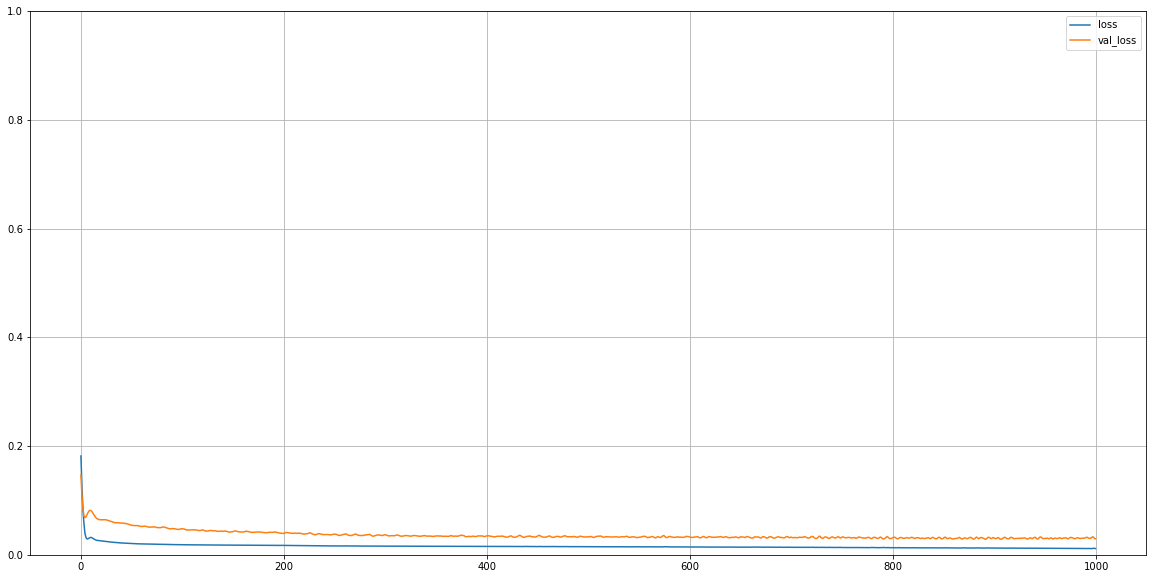

In [104]:
#### When we run the fit() function, it creates a History object containing the training parameters (history.params).
### fit() : Training parameters (history.params)
### fit() : The list of epochs it went through (history.epoch)
##  fit() : It contains a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch
pd.DataFrame(history.history).plot(figsize=(20,10))
plt.grid(True)
plt.gca().set_ylim(0,1) # This sets vertical range to [0-1]
plt.show()


### 5.5 make some predictions with the model

In [106]:
predictions = model4.predict(X_val_array_MODEL)
predictions


array([[0.32925212],
       [0.37599748],
       [0.27193564],
       [0.48817146],
       [0.36963445],
       [0.32317072],
       [0.37189764],
       [0.54905725],
       [0.44260412],
       [0.4987483 ],
       [0.55509084],
       [0.45177132],
       [0.7009579 ],
       [0.8310655 ],
       [0.5608755 ],
       [0.8721123 ],
       [0.77507466],
       [0.6428849 ],
       [0.70988333],
       [0.80024064]], dtype=float32)

In [107]:
# Unscale the data
predictions_unscaled=scaler.inverse_transform(predictions)
predictions_unscaled.shape
(20, 1)


(20, 1)

In [108]:
predictions_unscaled.shape


(20, 1)

In [110]:
# Flatten predictions
predictions_flat = predictions_unscaled.flatten()



In [111]:
predictions_flat.shape



(20,)

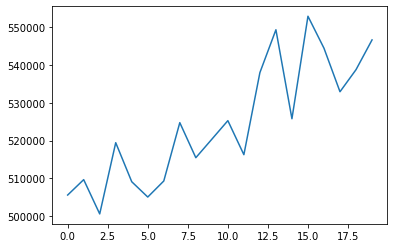

In [112]:
# Plot the unscaled predictions
plt.plot(predictions_unscaled)


In [113]:
len(predictions_unscaled)


20

In [123]:
# I need to find the right Indext ()
len(valdataf)


25

In [124]:
predictions_unscaled2 = pd.Series(predictions_flat, 
                                 # index=valdataf.index[5:])
                                index=valdataf.index[0:20])


In [125]:
forecastRNN = pd.Series(predictions_unscaled2, index = valdataf.index)

### 5.6 Plot RNN predictions 

In [126]:
forecastRNN = pd.Series(predictions_unscaled2, index = valdataf.index)

In [127]:
forecastRNN_rename = forecastNEURAL.rename('Training RNN forecast')

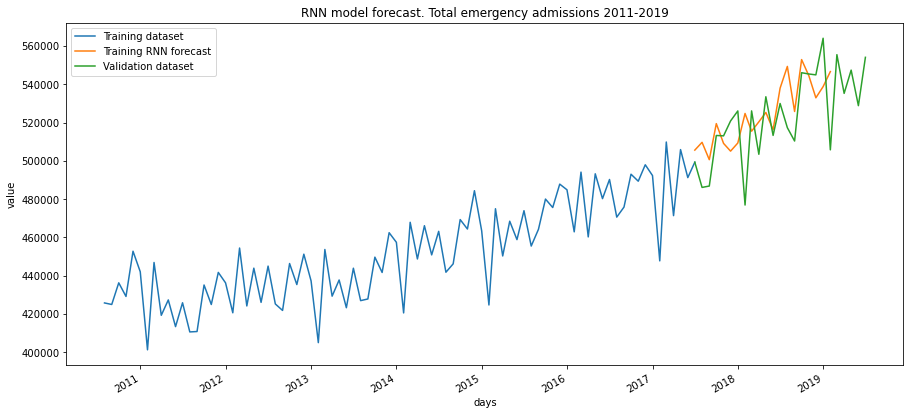

In [128]:
plt.figure(figsize=(15,7))
plt.title('RNN model forecast. Total emergency admissions 2011-2019')
plt.plot(traindataf, label = "Training dataset")  # Dataset 
forecastRNN_rename.plot() # Series 
plt.plot(valdataf, label = "Validation dataset") # Dataset
plt.legend()
plt.ylabel("value")
plt.xlabel("days")
plt.show()


### 6. Compute MAPE value

In [122]:
type(valdataf)

pandas.core.frame.DataFrame

In [129]:
type(forecastRNN)

pandas.core.series.Series

In [130]:
ValdataNEW = valdataf.rename(columns={'Total Emergency Admissions':'Value'})

In [131]:
fRNNdataframe = pd.DataFrame(forecastRNN)


In [132]:
ForecastNEW = fRNNdataframe.rename(columns={0:'Value'})

### 6.1 MAPE value for RNN model

In [133]:
def accuray_MAPE(ACT,FCAST):
  #  Value = abs((ACT-FCAST)/ACT).sum()/len(ACT)
    Value_percent = (abs((ACT-FCAST)/ACT).sum()/len(ACT))*100
    Mape_value = print(f"RNN model MAPE percent   {Value_percent}")
    #Mape_value_per = print(f"Seasonal ARIMA model MAPE {Value}")
    return Value_percent


In [134]:
accuray_MAPE(ValdataNEW,ForecastNEW)

RNN model MAPE percent   Value    2.464069
dtype: float64


Value    2.464069
dtype: float64